В цій частині ми знову будемо працювати з датасетом fasion_mnist.

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу, що використовує VGG16 в якості згорткової основи.

Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Під час навчання використовуйте прийоми донавчання та виділення ознак.

Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy import ndimage
import numpy as np

2024-01-18 10:31:33.817644: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 10:31:33.886562: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 10:31:33.886617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 10:31:33.888433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 10:31:33.898115: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 10:31:33.899146: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Завантажимо та підготуємо дані
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Конвертація чорно-білих зображень у зображення RGB
x_train_rgb = np.stack((x_train,) * 3, axis=-1)
x_test_rgb = np.stack((x_test,) * 3, axis=-1)

# Зміна розміру та нормалізація
x_train_rgb = tf.image.resize(x_train_rgb, (32, 32)) / 255.0
x_test_rgb = tf.image.resize(x_test_rgb, (32, 32)) / 255.0

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

2024-01-18 10:31:38.884018: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 737280000 exceeds 10% of free system memory.
2024-01-18 10:31:39.586016: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 737280000 exceeds 10% of free system memory.


In [3]:
# Завантажимо VGG16 без верхнього повнозв'язного шару та ваг
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Додамо верхній повнозв'язний шар
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Заморозимо ваги VGG16
base_model.trainable = False

# Скомпілюємо модель
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [5]:
# Використовуємо прийоми донавчання та виділення ознак
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [6]:
# Навчання моделі
histoy = model.fit(datagen.flow(x_train_rgb.numpy().reshape((-1, 32, 32, 3)), y_train, batch_size=64),
          steps_per_epoch=100,
          epochs=10,
          validation_data=(x_test_rgb.numpy().reshape((-1, 32, 32, 3)), y_test))


# Відновлення оригінальних розмірів тестового набору
x_test_restored = np.array([tf.image.resize(image, (32, 32)).numpy() for image in x_test_rgb])

# Оцінка точності на тестовому наборі
test_loss, test_acc = model.evaluate(x_test_restored, y_test)
print("Точність на тестовому наборі:", test_acc)

Epoch 1/10


/home/nomd/.local/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/home/nomd/.local/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


100/100 [==============================] - 74s 736ms/step - loss: 1.3593 - accuracy: 0.5266 - val_loss: 0.9129 - val_accuracy: 0.6878
Epoch 2/10
100/100 [==============================] - 72s 728ms/step - loss: 0.9381 - accuracy: 0.6644 - val_loss: 0.7869 - val_accuracy: 0.7166
Epoch 3/10
100/100 [==============================] - 72s 727ms/step - loss: 0.8448 - accuracy: 0.6997 - val_loss: 0.7437 - val_accuracy: 0.7328
Epoch 4/10
100/100 [==============================] - 74s 746ms/step - loss: 0.8133 - accuracy: 0.7088 - val_loss: 0.7303 - val_accuracy: 0.7398
Epoch 5/10
100/100 [==============================] - 75s 757ms/step - loss: 0.7402 - accuracy: 0.7369 - val_loss: 0.7086 - val_accuracy: 0.7469
Epoch 6/10
100/100 [==============================] - 75s 752ms/step - loss: 0.7478 - accuracy: 0.7334 - val_loss: 0.6861 - val_accuracy: 0.7490
Epoch 7/10
100/100 [==============================] - 76s 763ms/step - loss: 0.7221 - accuracy: 0.7439 - val_loss: 0.6739 - val_accuracy: 0.7

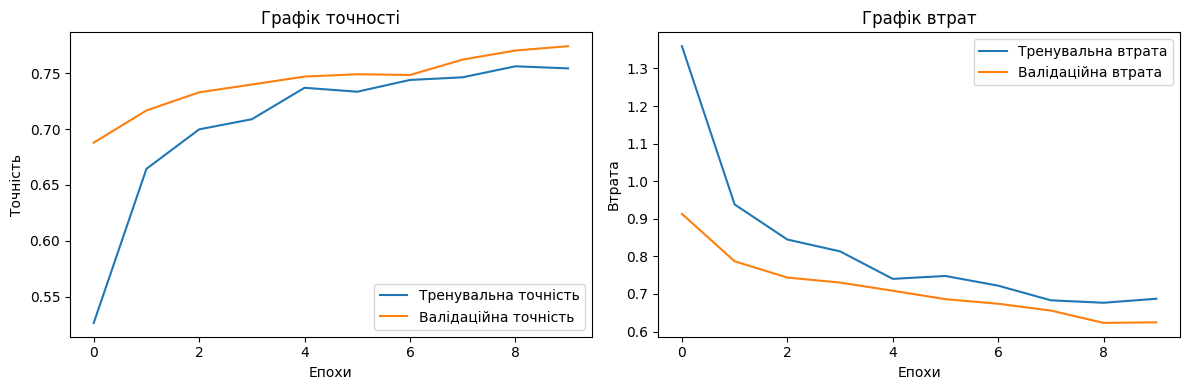

In [8]:
import matplotlib.pyplot as plt

# Вивід графіків точності та втрат
plt.figure(figsize=(12, 4))

# Графік точності на тренувальному та валідаційному наборі
plt.subplot(1, 2, 1)
plt.plot(histoy.history['accuracy'], label='Тренувальна точність')
plt.plot(histoy.history['val_accuracy'], label='Валідаційна точність')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.title('Графік точності')
plt.legend()

# Графік втрат на тренувальному та валідаційному наборі
plt.subplot(1, 2, 2)
plt.plot(histoy.history['loss'], label='Тренувальна втрата')
plt.plot(histoy.history['val_loss'], label='Валідаційна втрата')
plt.xlabel('Епохи')
plt.ylabel('Втрата')
plt.title('Графік втрат')
plt.legend()

plt.tight_layout()
plt.show()